<a href="https://colab.research.google.com/github/naomifridman/Introduction_to_deep_learning/blob/master/Deep_Learning_keras_lstm_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Deep Learning 
# RNN LSTM
### https://colah.github.io/posts/2015-08-Understanding-LSTMs/
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import utils_plot as uplot
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss

%matplotlib inline  

## Utilities

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [0]:
def drow_history_list(history_list, history_names=None,  metric=None):
    
    if metric is None:
        metric = 'loss'
        
    leg = []
    if history_names is not None:
        for n in history_names:
            leg.append('train ' + n)
            leg.append('test ' + n)
    else:
        for n in range(len(history_list)):
            leg.append('train ' + str(n))
            leg.append('test ' + str(n))
            
    for hist in history_list:
        
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+ metric], '--', linewidth=2)
        
        
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(leg, loc='best')
    plt.show()  

In [0]:
def drow_history(history, metric, i_start=0):
    if metric is None:
        metric = 'loss'
    plt.plot(history.history[metric][i_start:])
    plt.plot(history.history['val_'+ metric][i_start:])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

In [5]:
import keras
# Keras has many build in data sets
from keras.datasets import mnist
# Sequential is the basic feed forward neural network (FFN)
from keras.models import Sequential
# Dense is fully connected layer
# Dropout is a "noising" layer, to prevent over feet.
from keras.layers import Dense, Dropout
# Read about optimizers in keras documentation
from keras.optimizers import RMSprop
from keras import optimizers

Using TensorFlow backend.


In [0]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

# Recurrent Neural Networks
Recurrent neural networks have loops in them, allowing information to persist, they have `memory`.
![title](rnn1.png)
RNN are the natural architecture to learn sequence, such as:
* Speech recognition, 
* language modeling,
* translation, 
* image captioning… 
> Recomended: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

## The Problem of Long-Term Dependencies
One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task, such as using previous video frames might inform the understanding of the present frame. If RNNs could do this, they’d be extremely useful. But can they? It depends.
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc

## LSTM Networks
LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

### Example
https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc


In the proceeding section, we go over my solution to a Kaggle competition whose goal it is to perform sentiment analysis on a corpus of movie reviews. We’re asked to label each phrase on a scale of zero to four. The sentiment corresponding to each of the labels are:
* 0: negative
* 1: somewhat negative
* 2: neutral
* 3: somewhat positive
* 4: positive

## Kaggle
https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/data

kaggle competitions download -c movie-review-sentiment-analysis-kernels-only

In [8]:
import os
os.environ['KAGGLE_USERNAME']='ripcurl' #xxxxxx
os.environ['KAGGLE_KEY']='fe6a30f9313cb9751139964b31c0f83b' #xxxxxx
!kaggle competitions download -c movie-review-sentiment-analysis-kernels-only

  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 74.8MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 36.6MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 85.3MB/s]


In [9]:
!ls

sample_data  sampleSubmission.csv  test.tsv.zip  train.tsv.zip


In [10]:
!unzip train.tsv.zip

Archive:  train.tsv.zip
  inflating: train.tsv               


In [11]:
!unzip test.tsv.zip

Archive:  test.tsv.zip
  inflating: test.tsv                


In [12]:
!ls

sample_data	      test.tsv	    train.tsv
sampleSubmission.csv  test.tsv.zip  train.tsv.zip


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

## Load and preprocess data

In [14]:
df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [15]:
df_test = pd.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


### Clean data
Preprocess stage to clean words,prior to splitting them accoedingto space.

In [0]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [0]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

In [0]:
X_test = df_test['Phrase'].apply(lambda p: clean_text(p))

## Analize length
All Inputs to a neural network must be the same length. So we need to find the longestphrase, and padd the rest to the same longest length.

max phrase len: 53


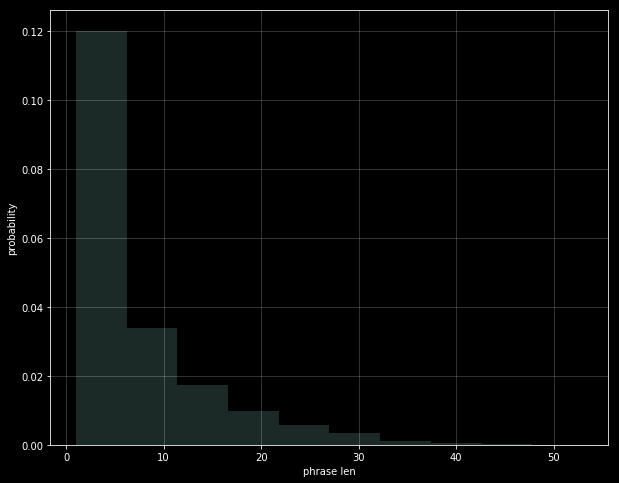

In [19]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

## Tokenize with keras preprocess tool,Tokenizer
The tokenizer imlement 2 steps:
1. Tokenize - Break phrases to words.
2. Vectorize - Embed words to numerical vector. We need to pre-decide the number of relevant words. The tokenizer, will embed only the most common num_words we pre-defined.


In [0]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)



## Padd sequence

In [0]:
X_train = pad_sequences(X_train, maxlen = max_phrase_len)

In [0]:
y_train = df_train['Sentiment']
y_train = to_categorical(y_train)

In [24]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_phrase_len)


AttributeError: ignored

## Build Keras model - train and predict

To understand the embeding layer, read:
* https://towardsdatascience.com/machine-learning-sentiment-analysis-and-word-embeddings-python-keras-example-4dfb93c5a6cf?source=post_page-----86001ceaaebc----------------------

In [25]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [26]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 140454 samples, validate on 15606 samples
Epoch 1/8
140454/140454 [==============================] - 60s 430us/step - loss: 1.0593 - acc: 0.5791 - val_loss: 1.0110 - val_acc: 0.5962
Epoch 2/8
140454/140454 [==============================] - 54s 388us/step - loss: 0.8561 - acc: 0.6564 - val_loss: 1.0075 - val_acc: 0.5961
Epoch 3/8
140454/140454 [==============================] - 55s 389us/step - loss: 0.8051 - acc: 0.6747 - val_loss: 1.0051 - val_acc: 0.6052
Epoch 4/8
140454/140454 [==============================] - 54s 387us/step - loss: 0.7709 - acc: 0.6874 - val_loss: 1.0082 - val_acc: 0.6082
Epoch 5/8
140454/140454 [==============================] - 55s 389us/step - loss: 0.7450 - acc: 0.6964 - val_loss: 1.0412 - val_acc: 0.6029
Epoch 6/8
140454/140454 [==============================] - 54s 387us/step - loss: 0.7241 - acc: 0.7031 - val_loss: 1.0401 - val_acc: 0.6068
Epoch 7/8
14045

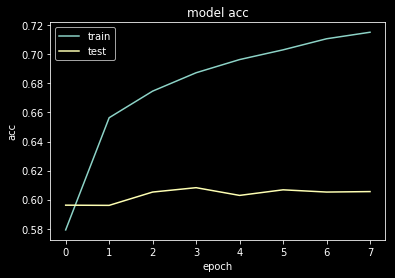

In [27]:
drow_history(history,'acc')

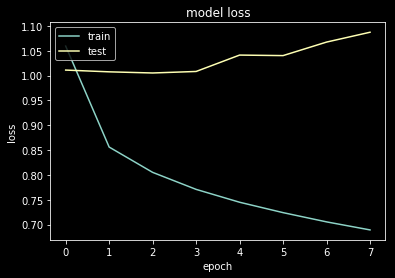

In [28]:
drow_history(history,'loss')

In [29]:
X_train.shape, X_test.shape

((156060, 53), (66292, 53))

In [0]:
pred = model_lstm.predict_classes(X_test)


In [31]:
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [0]:

df_test['Sentiment'] = pred
df_test[['Sentiment']].to_csv("submission.csv", index=False)

In [0]:
from google.colab import files
files.download('submission.csv')

## imbd data set, sentiment analysis
The argument num_words=10000 ensures we only keep the top 10,000 most frequently occurring words in the training set. The rare words are discarded to keep the size of the data manageable.


In [0]:
num_words = 10000

In [51]:
from keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


When we use keras.datasets.imdb to import the dataset into our program, it comes already preprocessed with tokenizer function we saw before.

In [52]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [0]:
word_index = imdb.get_word_index()
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

Now, we can use the decode_review function to display the text of the first review.

In [54]:
decode_review(X_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### Pad data to same length

In [0]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, Dense

In [55]:
len(X_train[0]), len(X_train[1]), len(X_train[5])

(218, 189, 43)

In [0]:
X_train = pad_sequences(
    X_train,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256
)
X_test = pad_sequences(
    X_test,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256
)

## Embeddings
When vectorizung word data, we get large sparse matrix.
This is where embeddings come in. Embeddings solve the core problems of sparse input data by mapping our high-dimensional data into a lower-dimensional space .
Keras Embedding layer parameters are:

* input_dim: The size of the vocabulary (i.e. number of distinct words) in the training set
* output_dim: The size of the embedding vectors
* input_length: The number of features in a sample (i.e. number of words in each document). For example, if all of our documents are comprised of 1000 words, the input length would be 1000.

As the network trains, the embeddings are optimized as well.

In [62]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=16, input_length=256))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [64]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.1,
    shuffle=True
)


Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 1s 36us/step - loss: 0.6910 - acc: 0.5412 - val_loss: 0.6873 - val_acc: 0.6568
Epoch 2/20
22500/22500 [==============================] - 0s 16us/step - loss: 0.6797 - acc: 0.7040 - val_loss: 0.6697 - val_acc: 0.7376
Epoch 3/20
22500/22500 [==============================] - 0s 16us/step - loss: 0.6522 - acc: 0.7481 - val_loss: 0.6330 - val_acc: 0.7688
Epoch 4/20
22500/22500 [==============================] - 0s 18us/step - loss: 0.6037 - acc: 0.7930 - val_loss: 0.5776 - val_acc: 0.7984
Epoch 5/20
22500/22500 [==============================] - 0s 15us/step - loss: 0.5402 - acc: 0.8233 - val_loss: 0.5150 - val_acc: 0.8244
Epoch 6/20
22500/22500 [==============================] - 0s 15us/step - loss: 0.4743 - acc: 0.8480 - val_loss: 0.4578 - val_acc: 0.8432
Epoch 7/20
22500/22500 [==============================] - 0s 16us/step - loss: 0.4163 - acc: 0.8650 - val_loss: 0.4123 - val_acc:

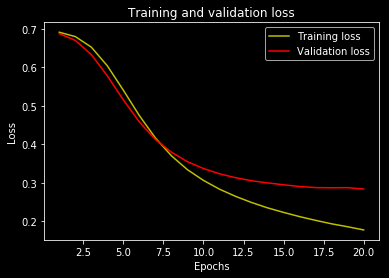

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

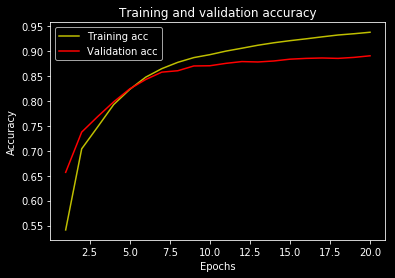

In [66]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [67]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

25000/25000 [==============================] - 1s 52us/step
0.8806
